In [211]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 

In [212]:
## Read landsat data 
os.chdir("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Volk_SEBAL_all")
file_list=os.listdir()
volk_landsat=[]
for i in range(len(file_list)):
    volk_landsat.append(pd.read_csv(file_list[i],parse_dates=["Date"]))

In [213]:
os.chdir("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Metadata")
st=pd.read_csv("SEBAL+Volk_all.csv")
## Read sentinel data for these stations 
os.chdir("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Sen1_all")
sen_list=os.listdir()
sen1=[]
for i in range(len(sen_list)):
    sen1.append(pd.read_csv(sen_list[i],parse_dates=["date"]))
    sen1[i]["Date"]=pd.to_datetime(sen1[i]["date"].dt.date)
print(sen_list==file_list)

True


In [214]:
## Fill the sentinel value to the next landsat date (This only fills for the next landsat date: Can modify to 2 if needed )
sen1_landsat=[]
for i in range(len(sen1)):
    # Merge the dataframes on the Date column using an outer join
    merged_df = pd.merge(volk_landsat[i], sen1[i], on='Date', how='outer')
    # Sort the dataframe by Date (ensures proper order for filling)
    merged_df.sort_values('Date', inplace=True)
    # List of columns to forward fill
    columns_to_fill = ['date','VV', 'VH',"angle"]
    # Add a column to track the gap in days
    merged_df['Gap'] = pd.NA
    # Forward fill each column conditionally
    for column in columns_to_fill:
        last_value = None
        for i, row in merged_df.iterrows():
            if pd.notna(row[column]):
                last_value = row[column]
                last_date = row['Date']

            elif last_value is not None:
                merged_df.at[i, column] = last_value
                merged_df.at[i, 'Gap'] = (row['Date'] - last_date).days

                last_value = None  # reset last_value to ensure single forward fill
    # Optionally, reset the index if you want the Date column back as a column
    merged_df.reset_index(drop=True, inplace=True)
    # print(merged_df)
    sen1_landsat.append(merged_df[(merged_df["NDVI"].notna()) & (merged_df["VV"].notna())])
for i in range(len(sen1_landsat)):
    if sen1_landsat[i].shape[0]!=0:
        sen1_landsat[i]=sen1_landsat[i].replace("<NA>", np.nan)
        sen1_landsat[i]["Gap"]=sen1_landsat[i]["Gap"].astype(dtype='Int64')

In [215]:
## Fill the sentinel value to the next landsat date (This only fills for the next landsat date: Can modify to 2 if needed )
sen1_landsat=[]
for i in range(len(sen1)):
    # Merge the dataframes on the Date column using an outer join
    merged_df = pd.merge(volk_landsat[i], sen1[i], on='Date', how='outer')
    # Sort the dataframe by Date (ensures proper order for filling)
    merged_df.sort_values('Date', inplace=True)
    # List of columns to forward fill
    columns_to_fill = ['date','VV', 'VH',"angle"]
    # Add a column to track the gap in days
    merged_df['Gap'] = pd.NA
    # Forward fill each column conditionally
    for column in columns_to_fill:
        last_value = None
        last_date = None
        fill_count = 0  # Counter to keep track of how many times we've filled
        for i, row in merged_df.iterrows():
            if pd.notna(row[column]):
                last_value = row[column]
                last_date = row['Date']
                fill_count = 0  # Reset the counter when we encounter a new value
            elif last_value is not None and fill_count < 5:
                merged_df.at[i, column] = last_value
                merged_df.at[i, 'Gap'] = (row['Date'] - last_date).days
                fill_count += 1
            elif fill_count >= 5:
                last_value = None  # Reset last_value after filling the next two dates
    # Optionally, reset the index if you want the Date column back as a column
    merged_df.reset_index(drop=True, inplace=True)
    # print(merged_df)
    sen1_landsat.append(merged_df[(merged_df["NDVI"].notna()) & (merged_df["VV"].notna())])
for i in range(len(sen1_landsat)):
    if sen1_landsat[i].shape[0]!=0:
        sen1_landsat[i]=sen1_landsat[i].replace("<NA>", np.nan)
        sen1_landsat[i]["Gap"]=sen1_landsat[i]["Gap"].astype(dtype='Int64')

Shape of the dataset 2880


<Axes: >

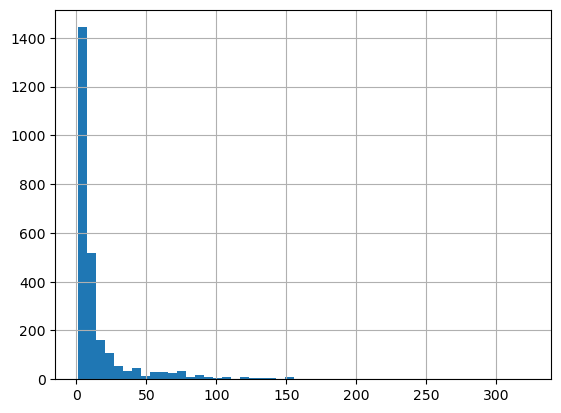

In [216]:
print("Shape of the dataset",pd.concat(sen1_landsat).shape[0])
pd.concat(sen1_landsat).Gap.hist(bins=50)

### Create features 
Since this include optical, thermal and microwave inputs: we will create some additional mixed features on top of what is present in Rao et al 2021: 
- Mixed microwave and thermal inputs of VV/LST, VH/LST
- Because we also have the model calculations as input we could also add VV/Rn, VH/Rn or something like that

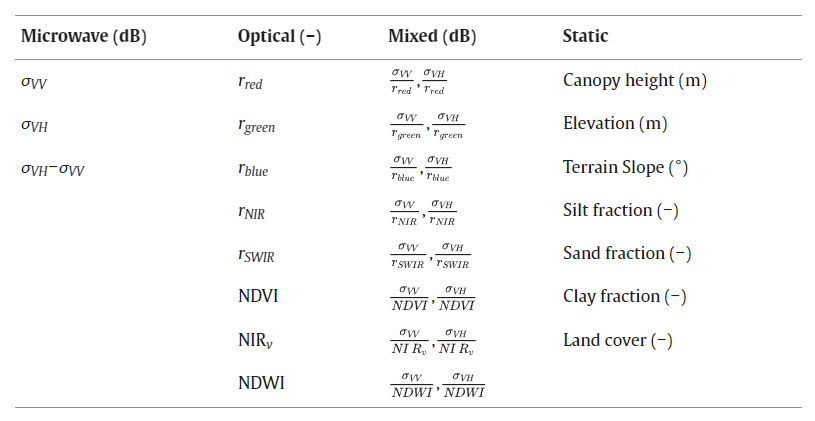


In [217]:
sen1_landsat[i].columns

Index(['Unnamed: 0_x', 'Date', 'B', 'R', 'GR', 'NIR', 'SWIR_1', 'SWIR_2',
       'ST_B10', 'NDVI', 'NDWI', 'ALFA', 'Tao_sw_1', 'Rs_down', 'Rl_down',
       'Rl_up', 'Rn', 'Ginst', 'Hinst', 'LEinst', 'LE_closed',
       'LE_Daily_model', 'Rn24h_G', 'AirT_G', 'RH_G', 'ux_G', 'Lat_volk',
       'Lon_volk', 'Elev_volk', 'Land_cover_volk', 'Site_name', 'Unnamed: 0_y',
       'longitude', 'latitude', 'date', 'VV', 'VH', 'angle', 'Gap'],
      dtype='object')

In [218]:
def backscatter_norm(listofdf,reference_angle_deg):
    for i in range(len(listofdf)):
        listofdf[i]["VV_norm"]=listofdf[i]["VV"]*(np.cos(np.radians(reference_angle_deg)))**2/(np.cos(np.radians(listofdf[i]["angle"])))**2
        listofdf[i]["VH_norm"]=listofdf[i]["VH"]*(np.cos(np.radians(reference_angle_deg)))**2/(np.cos(np.radians(listofdf[i]["angle"])))**2
    return listofdf
backscatter_norm(sen1_landsat,40)
sen1_landsat[0][["VV","VV_norm","VH","VH_norm"]]
def create_features(listofdf):
    for i in range(len(listofdf)):
        ## Optical
        listofdf[i]["VV_red"]=listofdf[i]["VV_norm"]/listofdf[i]["R"]
        listofdf[i]["VV_green"]=listofdf[i]["VV_norm"]/listofdf[i]["GR"]
        listofdf[i]["VV_blue"]=listofdf[i]["VV_norm"]/listofdf[i]["B"]
        listofdf[i]["VV_NIR"]=listofdf[i]["VV_norm"]/listofdf[i]["NIR"]
        listofdf[i]["VV_SWIR1"]=listofdf[i]["VV_norm"]/listofdf[i]["SWIR_1"]
        listofdf[i]["VV_SWIR2"]=listofdf[i]["VV_norm"]/listofdf[i]["SWIR_2"]
        listofdf[i]["VV_NDVI"]=listofdf[i]["VV_norm"]/listofdf[i]["NDVI"]
        listofdf[i]["VV_NDWI"]=listofdf[i]["VV_norm"]/listofdf[i]["NDWI"]
##-----------------------------------
        listofdf[i]["VH_red"]=listofdf[i]["VH_norm"]/listofdf[i]["R"]
        listofdf[i]["VH_green"]=listofdf[i]["VH_norm"]/listofdf[i]["GR"]
        listofdf[i]["VH_blue"]=listofdf[i]["VH_norm"]/listofdf[i]["B"]
        listofdf[i]["VH_NIR"]=listofdf[i]["VH_norm"]/listofdf[i]["NIR"]
        listofdf[i]["VH_SWIR1"]=listofdf[i]["VH_norm"]/listofdf[i]["SWIR_1"]
        listofdf[i]["VH_SWIR2"]=listofdf[i]["VH_norm"]/listofdf[i]["SWIR_2"]
        listofdf[i]["VH_NDVI"]=listofdf[i]["VH_norm"]/listofdf[i]["NDVI"]
        listofdf[i]["VH_NDWI"]=listofdf[i]["VH_norm"]/listofdf[i]["NDWI"]
    ### TIR+Microwave
        listofdf[i]["VH_LST"]=listofdf[i]["VH_norm"]/listofdf[i]["ST_B10"]
        listofdf[i]["VV_LST"]=listofdf[i]["VV_norm"]/listofdf[i]["ST_B10"]
    ## Only microwave
        listofdf[i]["VH-VV"]=listofdf[i]["VH_norm"]-listofdf[i]["VV_norm"]
    return listofdf
create_features(sen1_landsat)


[    Unnamed: 0_x       Date         B         R        GR       NIR    SWIR_1  \
 37           3.0 2018-03-03  0.039827  0.069060  0.068620  0.212225  0.168692   
 42           6.0 2018-04-20  0.021182  0.031495  0.043568  0.445178  0.118972   
 44           7.0 2018-05-06  0.033915  0.049728  0.061497  0.442868  0.152853   
 46           8.0 2018-05-22  0.067492  0.142678  0.122135  0.403762  0.223362   
 
       SWIR_2      ST_B10      NDVI  ...    VH_green     VH_blue     VH_NIR  \
 37  0.111602  296.323498  0.508968  ... -242.493351 -417.799102 -78.406850   
 42  0.055695  298.217081  0.867855  ... -439.902502 -904.777635 -43.051260   
 44  0.079510  303.908084  0.798100  ... -322.992179 -585.676294 -44.851364   
 46  0.128597  306.734787  0.477793  ... -142.152097 -257.239639 -42.999898   
 
       VH_SWIR1    VH_SWIR2    VH_NDVI    VH_NDWI    VH_LST    VV_LST     VH-VV  
 37  -98.640389 -149.099650 -32.693413  32.542258 -0.056154 -0.031999 -7.157698  
 42 -161.091448 -344.114413

In [219]:
##  Write the files in a folder 
for i in range(len(sen1_landsat)):
    if sen1_landsat[i][sen1_landsat[i]["Gap"]<90].shape[0]>=1:
        sen1_landsat[i].to_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Volk_SEBLA_Sen5\\"+sen1_landsat[i]["Site_name"].iloc[0]+".csv")
    print(sen1_landsat[i][sen1_landsat[i]["Gap"]<90].shape)


(4, 60)
(82, 60)
(124, 60)
(85, 60)
(25, 60)
(19, 60)
(6, 60)
(5, 60)
(25, 60)
(23, 60)
(24, 60)
(23, 60)
(20, 60)
(70, 60)
(28, 60)
(66, 60)
(10, 60)
(5, 60)
(5, 60)
(2, 60)
(1, 60)
(4, 60)
(3, 60)
(33, 60)
(27, 60)
(18, 60)
(71, 60)
(84, 60)
(74, 60)
(0, 60)
(53, 60)
(14, 60)
(16, 60)
(54, 60)
(24, 60)
(3, 60)
(3, 60)
(59, 60)
(37, 60)
(39, 60)
(4, 60)
(44, 60)
(45, 60)
(0, 60)
(0, 60)
(0, 60)
(27, 60)
(49, 60)
(45, 60)
(48, 60)
(0, 60)
(0, 60)
(0, 60)
(28, 60)
(2, 60)
(2, 60)
(0, 60)
(0, 60)
(15, 60)
(7, 60)
(47, 60)
(9, 60)
(11, 60)
(32, 60)
(45, 60)
(0, 60)
(0, 60)
(94, 60)
(0, 60)
(69, 60)
(62, 60)
(46, 60)
(42, 60)
(75, 60)
(45, 60)
(171, 60)
(14, 60)
(52, 60)
(11, 60)
(10, 60)
(14, 60)
(12, 60)
(1, 60)
(10, 60)
(5, 60)
(28, 60)
(6, 60)
(9, 60)
(13, 60)
(8, 60)


### Plotting the train and test sites on a map for this


In [166]:
## Let's map the data that we have to get an idea of the spatial scale we can map 
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import matplotlib as mpl
import geopandas as gpd

In [167]:
os.chdir("D:\\Backup\\Rouhin_Lenovo\\US_project\\US_Project\\Shapefiles")
us=gpd.read_file("s_11au16.shp")
us=us[us["STATE"]!="AK"]

In [168]:
## Read the train test split from ML et physics notebook 
summary_df_val=pd.read_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Train_test_sites\\ML_Sen1\\train_seed_sen_3.csv")
summary_df_train=pd.read_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Train_test_sites\\ML_Sen1\\val_seed_sen_3.csv")

c:\Users\rouhi\anaconda3\envs\rs\Lib\site-packages\cartopy\mpl\geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  result = super().scatter(*args, **kwargs)


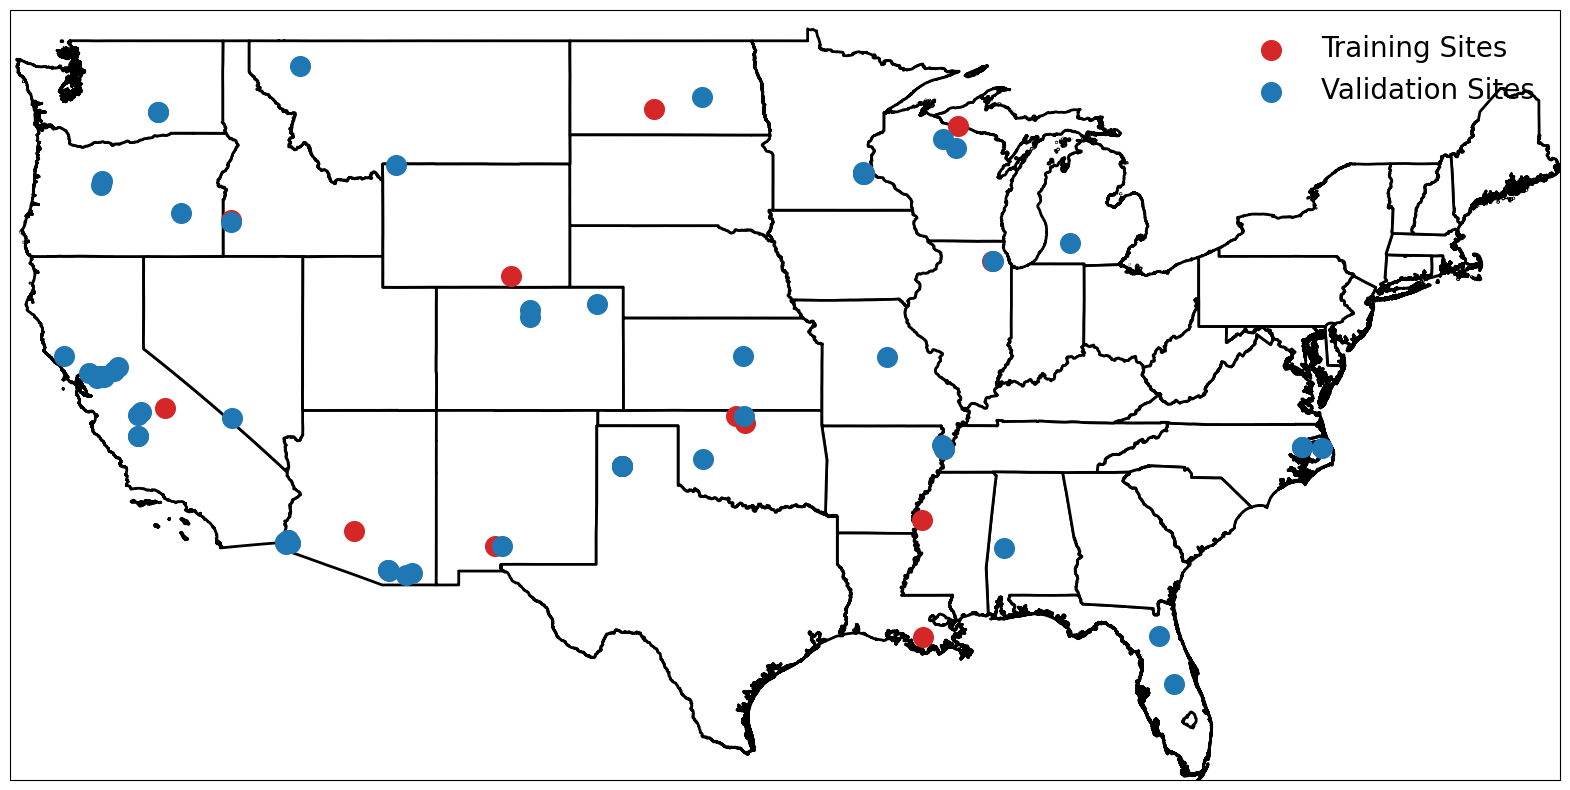

In [169]:
### To put this on a map 
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,10),frameon=False)
gs1 = gridspec.GridSpec(1, 1)
axs.set_aspect("auto")
# axs[1].set_aspect("auto")
# axs[1,0].set_aspect("auto")
# axs[1,1].set_aspect("auto")
fig.subplots_adjust(wspace=0,hspace=0)
axs.add_geometries(us.geometry, ccrs.PlateCarree(), facecolor='white', edgecolor='black',linewidth=2)
axs.set_extent([-125, -67,25, 50], crs=ccrs.PlateCarree())
#--------------------------------
# define the bins and normalize
a=plt.cm.RdYlBu
cmap=a.reversed()
# bounds = np.linspace(0,2,9)
bounds=np.linspace(0,100,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmap.set_over("pink")
# #---------------
p=axs.scatter(x=summary_df_train.Lon, y=summary_df_train.Lat,
            c="tab:red",
            s=200,
            alpha=1,transform=ccrs.PlateCarree(),zorder=2,cmap=cmap, norm=norm,label="Training Sites") ## Important
axs.scatter(x=summary_df_val.Lon, y=summary_df_val.Lat,
            c="tab:blue",
            s=200,
            alpha=1,transform=ccrs.PlateCarree(),zorder=2,cmap=cmap, norm=norm,label="Validation Sites")
axs.legend(fontsize=20,frameon=False)
# ax2 = fig.add_axes([0.92, 0.3, 0.02, 0.5])
# cb = fig.colorbar(p,cax=ax2, cmap=cmap, norm=norm,
#     ticks=bounds, boundaries=bounds,extend="max")
# ticklabels = ["0","10","20","30","40","50","60","70","80",'90','100']
# # ticklabels = ["0","0.25","0.5","0.75","1","1.25","1.5","1.75","2","2.25"]

# cb.set_ticklabels(ticklabels,fontsize=25)
# # #annotations 
# axs.annotate("No. of Points",xy=(-125,28.5),fontsize=25,annotation_clip=False)
# #annotations 
# axs[0].annotate("(a) CIMIS PM",xy=(-123.8,42.5),fontsize=35,annotation_clip=False)
# axs[1].annotate("(b) FAO-PM ",xy=(-123.8,42.5),fontsize=35,annotation_clip=False)
# # axs[1,0].annotate("(c) ETo PT",xy=(-123,42.5),fontsize=35,annotation_clip=False)
# # axs[1,1].annotate("(d) ETo SdB",xy=(-123,42.5),fontsize=35,annotation_clip=False)
# # mpl.rcParams['axes.linewidth'] = 1
# # axs[0].annotate("Penman Monteith")
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 2
# [s.set_frame_on(False) for s in axs.flatten()]
